In [1]:
import pandas as pd

import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go

In [2]:
!pip install chart_studio

In [50]:
import chart_studio.plotly as py
import chart_studio.tools as tls
from ipywidgets import interactive, HBox, VBox



In [7]:
import sys
import pandas as pd

    
def get_table(link_1,link_2):

    df = pd.read_html(link_1)[0]
    df_2 = pd.read_html(link_2)[0]
    df = df.dropna(subset = ['MP'])
    df_2 = df_2.dropna(subset = ['MP'])
    df = df[df['MP'] != 'MP']
    df_2 = df_2[df_2['MP'] != 'MP']
    final_df = df.merge(df_2)
    final_df['MP'] = final_df['MP'].astype(int)
    #final_df = final_df[final_df['MP'] >700]
    
    final_df = final_df.drop(columns = ['Unnamed: 24','Unnamed: 29','Unnamed: 19'])
    send_df = final_df[['Player','TS%','PTS','MP','Tm']]
    return send_df
    
def main(my_dict):
    team = my_dict['team']
    df = get_table()
    return df.to_dict()


In [8]:
link_1 ='https://www.basketball-reference.com/leagues/NBA_2022_per_poss.html#per_poss_stats'
link_2 = 'https://www.basketball-reference.com/leagues/NBA_2022_advanced.html#advanced_stat'

df = pd.read_html(link_1)[0]
df_2 = pd.read_html(link_2)[0]

#df_2 = df_2.dropna()


In [9]:
df = get_table(link_1,link_2)
df

,Player,TS%,PTS,MP,Tm
0,Precious Achiuwa,.503,19.2,1725,TOR
1,Steven Adams,.560,12.6,1999,MEM
2,Bam Adebayo,.608,29.3,1825,MIA
3,Santi Aldama,.452,17.5,360,MEM
4,LaMarcus Aldridge,.604,28.0,1050,BRK
...,...,...,...,...,...
807,Thaddeus Young,.526,17.3,475,TOR
808,Trae Young,.603,39.9,2652,ATL
809,Omer Yurtseven,.546,21.2,706,MIA
810,Cody Zeller,.627,19.3,355,POR


In [59]:
df = df[['Player','PTS','MP','Tm']]
df_2 = df_2[['Player','TS%','Tm']]

df = df.drop_duplicates()
df_2 = df_2.drop_duplicates()

df_3 = df_2.merge(df, on = ['Player','Tm'],how = 'left')
df_3

,Player,TS%,Tm,PTS,MP
0,Precious Achiuwa,.503,TOR,19.2,1725
1,Steven Adams,.560,MEM,12.6,1999
2,Bam Adebayo,.608,MIA,29.3,1825
3,Santi Aldama,.452,MEM,17.5,360
4,LaMarcus Aldridge,.604,BRK,28.0,1050
...,...,...,...,...,...
808,Thaddeus Young,.526,TOR,17.3,475
809,Trae Young,.603,ATL,39.9,2652
810,Omer Yurtseven,.546,MIA,21.2,706
811,Cody Zeller,.627,POR,19.3,355


In [60]:
final_df = df_3

len(final_df)

813

In [61]:
 final_df = final_df[final_df['MP'] >700]

TypeError: '>' not supported between instances of 'str' and 'int'

In [17]:
df[df['Player'] == 'James Harden']

,Player,PTS,MP,Tm
292,James Harden,29.0,2419,TOT
293,James Harden,29.5,1627,BRK
294,James Harden,27.8,792,PHI


In [7]:
my_dict = {"__ow_headers":{"accept":"application/json","accept-encoding":"gzip, deflate","content-type":"application/json","cookie":"dtCookie=v_4_srv_1_sn_9F28C6E505BB8BBFF658B23EF28F0194_perc_100000_ol_0_mul_1_app-3Aea7c4b59f27d43eb_1_rcs-3Acss_0","host":"us-south.functions.appdomain.cloud","user-agent":"Watson Assistant Service","x-forwarded-for":"172.69.70.135","x-forwarded-host":"us-south.functions.appdomain.cloud","x-forwarded-port":"443","x-forwarded-proto":"https","x-forwarded-scheme":"https","x-global-transaction-id":"43795378-c04a-451d-9b8b-f467983d966f","x-real-ip":"172.69.70.135","x-request-id":"aea2bba860e6b6a170b222b7dc91be49","x-scheme":"https","x-watson-conversation-id":"ef93964e-67d3-4ba4-a026-aeef2495b580","x-watson-origin":"Watson Assistant Service","x-watson-session-id":"ef93964e-67d3-4ba4-a026-aeef2495b580","x-watson-skill-id":"cf9780c5-7ab6-47a0-af37-9770f16022c8","x-watson-userinfo":"watson_service=Watson Assistant Service; workspace_id=cf9780c5-7ab6-47a0-af37-9770f16022c8; transaction_id=43795378-c04a-451d-9b8b-f467983d966f","x-watson-webhook-source-workspace":"cf9780c5-7ab6-47a0-af37-9770f16022c8"},"__ow_method":"post","__ow_path":"","team":"GSW"}

In [5]:
df = get_table()
teams = list(df['Tm'].unique())

0.455
0.745


In [6]:
teams

['TOR',
 'MEM',
 'MIA',
 'BRK',
 'TOT',
 'MIL',
 'CLE',
 'NOP',
 'LAL',
 'ORL',
 'WAS',
 'PHO',
 'CHO',
 'CHI',
 'SAC',
 'NYK',
 'DEN',
 'SAS',
 'LAC',
 'OKC',
 'MIN',
 'DET',
 'IND',
 'GSW',
 'ATL',
 'UTA',
 'BOS',
 'DAL',
 'HOU',
 'POR',
 'PHI']

In [7]:
my_list = []
i = 0
length = len(teams)
seen = [False for i in range(length+ 1) ]

seen[i] = True
my_list.append(dict(label = 'all_teams',

                  args = [{'visible':[i for i in seen]},
                          {'title': 'all_teams',
                           'showlegend':False}]))
seen[i] = False
i +=1
for team in teams:
    #print(i)
    df_team = df[df['Tm'] == team]
    seen[i] = True
    
    my_list.append(dict(label = team,
                  method = 'update',

                  args = [{'visible':[i for i in seen]},
                          {'title': team,
                           'showlegend':False}]))
    seen[i] = False
    i+=1


In [8]:
df['PTS'].max()

df['TS%'] *= 100

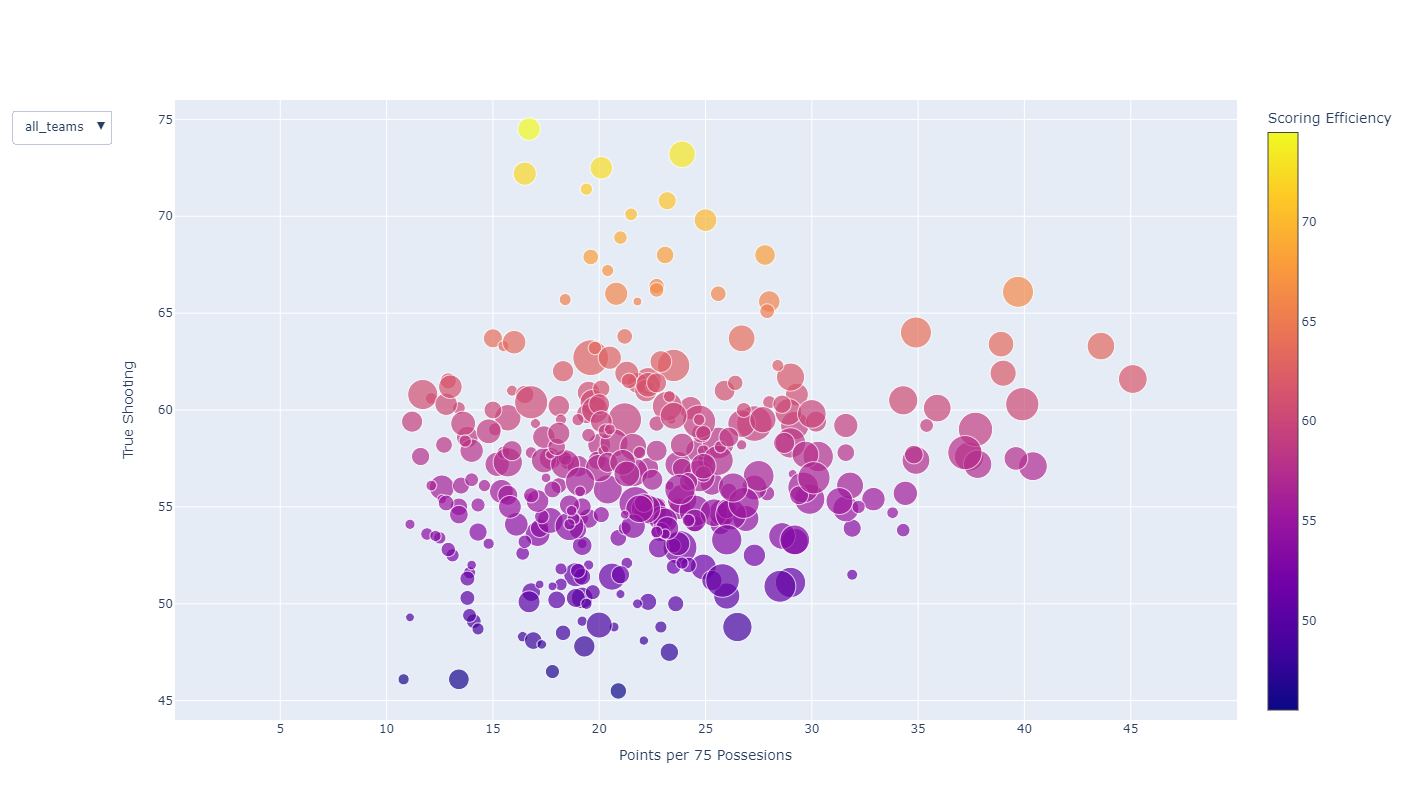

In [13]:
zmax = df['TS%'].max()
zmin = df['TS%'].min()

fig = go.Figure()
fig.add_trace(
        go.Scatter(

            visible = True,
            x = df['PTS'],
            y = df['TS%'],
            text = df['Player'],
            hovertemplate =
            '<b>%{text}</b>'+
    '<br><i>Points per 75</i>: %{x:.2f}<br>'+
    'True Shooting: %{y}'
    ,
            name = 'all_teams',
            marker=dict(
            cmin=zmin ,
            cmax=zmax,
            size=df['MP'] / 80,
            colorbar=dict(
            title="Scoring Efficiency",
            tickformatstops = [{'dtickrange': [40,80]
                              }]
           
    
        ),
        autocolorscale = True,
        color=  df['TS%'],

    ),
   

    mode="markers"
        ))

for team in teams:
    df_team = df[df['Tm'] == team]
   
    
    fig.add_trace(
        go.Scatter(

            visible = False,
            x = df_team['PTS'],
            y = df_team['TS%'],
            text = df_team['Player'],
            hovertemplate =
            '<b>%{text}</b>'+
    '<br><i>Points per 75</i>: %{x:.2f}<br>'+
    'True Shooting: %{y}'
    ,
            name = team,
            marker=dict(
            cmin=zmin ,
            cmax=zmax,
            size=df_team['MP'] / 80,
            colorbar=dict(
            title="Scoring Efficiency",
            tickformatstops = [{'dtickrange': [40,80]
                              }]
           
    
        ),
        autocolorscale = True,
        color=  df_team['TS%'],

    ),
   

    mode="markers"
        )
        
    )  
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
showlegend= False)  
fig.update_layout(
updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons= my_list,
        direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            
         
)],
)
fig.update_layout(yaxis_range=[44,76], xaxis_range = [0,50])
fig.update_yaxes(tickvals=[i for i in range(45,80,5)], title_text = "True Shooting",)
fig.update_xaxes(tickvals = [i for i in range (5,50,5)], title_text = 'Points per 75 Possesions')

fig.show()

In [14]:
fig.write_html("index.html")